# Perform Random Forest Test

___

# Import library and Data Setup
Import necessary library

**Setup the training data and testing data set**

The train.csv and test.csv were split using [export_train_test_set.ipynb](https://github.com/cmxteng/aiforsea-traffic-management/blob/master/export_train_test_set.ipynb) 

It is split into test dataset (day 61 and timestamp <= 11:45) and train dataset (day 1 to day 60).

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

%matplotlib inline

In [2]:
import seaborn as sns
sns.set_style('whitegrid')

### Get the Data

**Read in the training csv file and Hold-out test csv file as a DataFrame called trainset and testset respectively.**

In [3]:
trainset = pd.read_csv('train60.csv')

In [23]:
testset = pd.read_csv('test61_t1145.csv')

In [25]:
testset.head()

,geohash6,day,timestamp,demand
0,qp03mq,61,11:15,0.015526
1,qp09sf,61,0:0,0.027095
2,qp03xt,61,0:45,0.265624
3,qp09th,61,0:15,0.017085
4,qp09mr,61,0:45,0.042417


In [7]:
trainset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4132706 entries, 0 to 4132705
Data columns (total 4 columns):
geohash6     object
day          int64
timestamp    object
demand       float64
dtypes: float64(1), int64(1), object(2)
memory usage: 126.1+ MB


In [26]:
testset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11165 entries, 0 to 11164
Data columns (total 4 columns):
geohash6     11165 non-null object
day          11165 non-null int64
timestamp    11165 non-null object
demand       11165 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 349.0+ KB


### Convert timestamp to time (in hour format) in float
* 15 minute: 0.25 hour
* 30 minute: 0.50 hour
* 45 minute: 0.75 hour

In [9]:
# extract hour and minute from timestamp column for trainset
trainset[['hour','min']] = trainset['timestamp'].str.split(':',expand=True).astype('int64')
trainset['time'] = trainset['hour']+(trainset['min']/60.0)

In [27]:
# extract hour and minute from timestamp column for testset
testset[['hour','min']] = testset['timestamp'].str.split(':',expand=True).astype('int64')
testset['time'] = testset['hour']+(testset['min']/60.0)

### Decode Geohash6

In [11]:
import geohash

In [12]:
trainset['coordinate'] = trainset.geohash6.apply(lambda c: geohash.decode(c))

trainset['coordinate'].tolist()
trainset[['latitude', 'longitude']] = pd.DataFrame(trainset['coordinate'].tolist(), index=trainset.index)

In [28]:
testset['coordinate'] = testset.geohash6.apply(lambda c: geohash.decode(c))

testset['coordinate'].tolist()
testset[['latitude', 'longitude']] = pd.DataFrame(testset['coordinate'].tolist(), index=testset.index)

___

## Setting up the Train Test Data

**Get data ready for the regression models.**


Check data info again

In [14]:
X_train = trainset[['time','day','latitude','longitude']].values
y_train = trainset['demand'].values

In [29]:
X_test = testset[['time','day','latitude','longitude']].values
y_test = testset['demand'].values

In [16]:
print(X_train.shape)
print(y_train.shape)

(4132706, 4)
(4132706,)


In [30]:
print(X_test.shape)
print(y_test.shape)

(11165, 4)
(11165,)


___

# Random Forest Model

In [18]:
from sklearn.ensemble import RandomForestRegressor

## New Random Forest Model

Set up a new parameter for the new random forest model based on the grid search, **n_estimator =30**, **max_depth = 40** and **min_samples_leaf = 2**.

In [19]:
new_forest = RandomForestRegressor(n_estimators=30,max_depth=40,min_samples_leaf=2, n_jobs= -1)

In [20]:
new_forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=40,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

### Cross Validation for new Random Forest model

In [26]:
from sklearn.model_selection import cross_val_score

In [16]:
new_scores_rfr = cross_val_score(new_forest, X_train, y_train, cv=10, scoring='explained_variance')

In [17]:
print('Scores for k=10 fold validation:',new_scores_rfr)
print("Estimated EV: %0.4f (+/- %0.4f)" % (new_scores_rfr.mean(), new_scores_rfr.std() * 2))

Scores for k=10 fold validation: [0.95548588 0.95556447 0.95606693 0.95583615 0.95542723 0.95599478
 0.95574413 0.95590705 0.95559601 0.95581935]
Estimated EV: 0.9557 (+/- 0.0004)


In [27]:
new_rmse_rfr = cross_val_score(new_forest, X_train, y_train, cv=10,scoring='neg_mean_squared_error')

In [28]:
print('Scores for k=10 fold validation:',new_rmse_rfr)
print("MSE: %0.4f (+/- %0.4f)" % (new_rmse_rfr.mean(), new_rmse_rfr.std() * 2))

Scores for k=10 fold validation: [-0.00096701 -0.00098473 -0.00098129 -0.00096521 -0.00097666 -0.00098359
 -0.00097312 -0.00098794 -0.00097909 -0.00098219]
MSE: -0.0010 (+/- 0.0000)


In [29]:
math.sqrt(-(new_rmse_rfr.mean()))

0.03127431873335827

### New Prediction for New Random Forest test dataset

In [31]:
# Predicting a random forest result
new_forest_pred = new_forest.predict(X_test)
new_forest_score = new_forest.score(X_test, y_test)
print(new_forest_score)

0.7692703842274707


In [32]:
# calculate forest MAE, MSE, RMSE!
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, new_forest_pred))
print('MSE:', metrics.mean_squared_error(y_test, new_forest_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, new_forest_pred)))

MAE: 0.0469052954114401
MSE: 0.006902576375875168
RMSE: 0.0830817451422102


### Residuals

Explore the residuals to make sure everything was okay with the data. 

**Plot a histogram of the residuals and make sure it looks normally distributed.**

(0, 30)

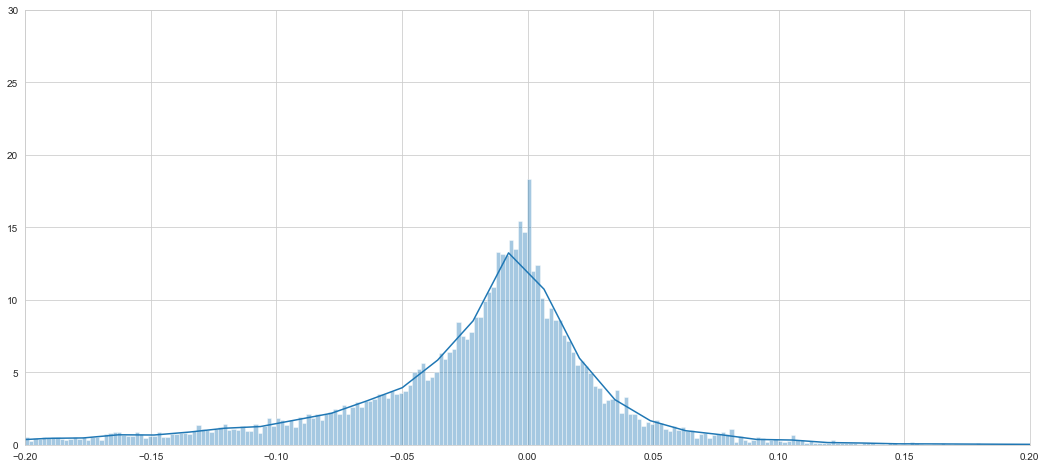

In [33]:
plt.figure(figsize=(18,8))
sns.distplot((y_test-new_forest_pred),bins=1000);
plt.xlim(-0.2,0.2)
plt.ylim(0,30)

The table shown is the results of Random Forest:

| New Models             | Random Forest |
|------------------------|---------------|
|CV Train RMSE:          | 0.0312        |
|Prediction RMSE:        | 0.0831        |


___